## 1. EDA & Preprocessing

- 1.1. Loading the Data
- 1.2. Missing Values
- 1.3. Correlation Analysis
- 1.4. Dealing with Imbalanced Categories
    - 1.4.1. Binning
- 1.5. Encoding Categorical Variables
- 1.6. MinMax Scaling
- 1.7. KNN Imputation
- 1.8. Dealing with Extreme Values

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import re
from sklearn.impute import KNNImputer
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

### 1.1. Loading the data

In [2]:
df = pd.read_csv('data/data.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [3]:
## Checking the dimensions of the dataset: 75757 rows, 64 columns
df.shape

(75757, 64)

In [4]:
## Summary Statistics for Building Characteristics
df.loc[:,['site_eui', 'energy_star_rating', 'floor_area', 'year_built', 'ELEVATION', 
          'Year_Factor', 'State_Factor']].describe()

,site_eui,energy_star_rating,floor_area,year_built,ELEVATION,Year_Factor
count,75757.000000,49048.000000,7.575700e+04,73920.000000,75757.000000,75757.000000
mean,82.584693,61.048605,1.659839e+05,1952.306764,39.506323,4.367755
std,58.255403,28.663683,2.468758e+05,37.053619,60.656596,1.471441
min,1.001169,0.000000,9.430000e+02,0.000000,-6.400000,1.000000
25%,54.528601,40.000000,6.237900e+04,1927.000000,11.900000,3.000000
50%,75.293716,67.000000,9.136700e+04,1951.000000,25.000000,5.000000
75%,97.277534,85.000000,1.660000e+05,1977.000000,42.700000,6.000000
max,997.866120,100.000000,6.385382e+06,2015.000000,1924.500000,6.000000


In [5]:
## Checking data types of the columns
print(df.dtypes)

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
                              ...   
direction_peak_wind_speed    float64
max_wind_speed               float64
days_with_fog                float64
site_eui                     float64
id                             int64
Length: 64, dtype: object


In [6]:
## Dropping 'id' because it is a unique identifier of the building hence not an important feature for modelling
df.drop(["id"], axis=1, inplace=True)

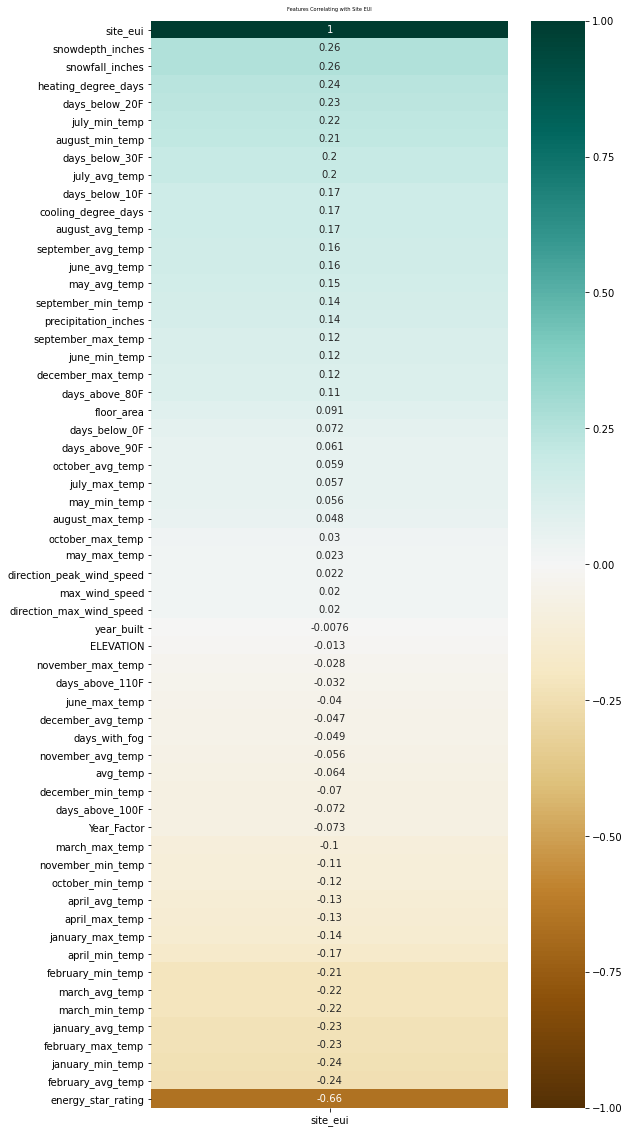

In [7]:
## Checking what features correlate with Site EUI and how much
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(df.corr(method = 'spearman')[['site_eui']].sort_values(by='site_eui', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Site EUI', fontdict={'fontsize':5}, pad=10);

### 1.2. Missing Values

In [8]:
## Checking the number of rows with atleast one missing value
df.shape[0] - df.dropna().shape[0]

64448

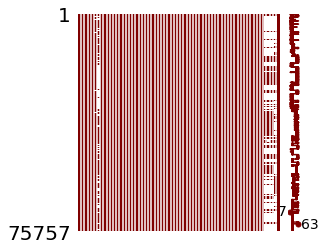

In [9]:
## white lines/spaces represent missing values
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

In [10]:
## Checking the % of missing values in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df[missing_value_df.percent_missing != 0.0].drop('column_name',1)

,percent_missing
year_built,2.424858
energy_star_rating,35.256148
direction_max_wind_speed,54.228652
direction_peak_wind_speed,55.190939
max_wind_speed,54.228652
days_with_fog,60.451179


In [11]:
## Dropping columns with more than 50% values missing
col_high_missing = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
df = df.drop(col_high_missing,1)
df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,47.911202,26,2,0,0,6,0,0,0,48.404398
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,47.911202,26,2,0,0,6,0,0,0,592.022750


In [12]:
## Dropping any duplicate rows present
df.drop_duplicates(inplace=True)
df.shape

(75718, 59)

### 1.3. Correlation Analysis

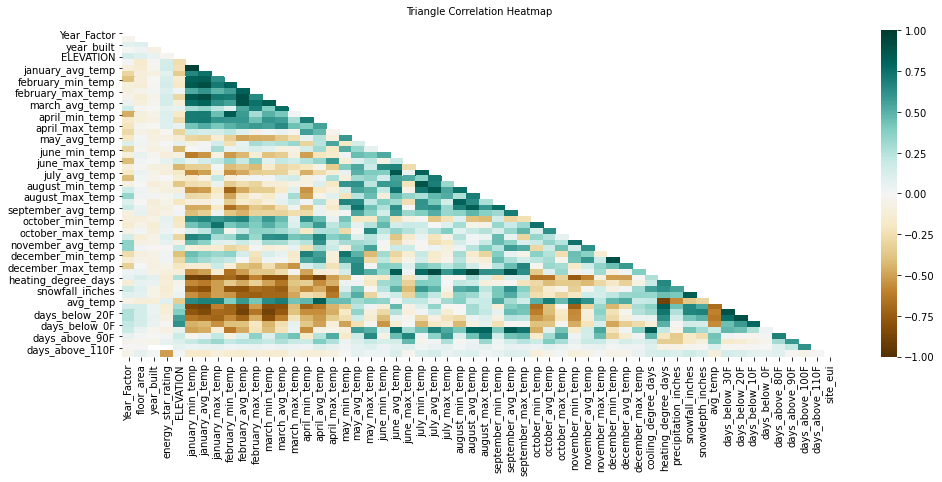

In [13]:
## Triangle Correlation Matrix
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(method = 'spearman'), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [15]:
## Extracting highly correlated features from the correlation matrix with the specified threshold i.e.
## absolute value of the correlation coefficient 

#' @param df1: dataframe 
#' @param threshold: absolute value of correlation coefficient
#' @return a set with pairs of highly correlated features based on the threshold set above

def pairwise_correlation(df1, threshold):
    highly_correlated = set()
    corr_mat = df1.corr(method = 'spearman')
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (np.abs(corr_mat.iloc[i, j]) >= threshold) and ((corr_mat.columns[j], corr_mat.columns[i]) not in highly_correlated):
                col = (corr_mat.columns[i], corr_mat.columns[j])
                highly_correlated.add(col)

    return highly_correlated

highly_correlated = pairwise_correlation(df, 0.95)
highly_correlated

{('days_below_20F', 'february_avg_temp'),
 ('january_avg_temp', 'january_min_temp')}

In [16]:
## Removing one of the correlated feature from the january_temp set
## Not removing any features from the first pair because it seems coincidental because of the obvious seasonal correlation
## not conclusive whether we can remove one or the other at this step
df.drop(columns=['january_min_temp'], axis=1, inplace=True)

### 1.4. Dealing with Imbalanced Categories

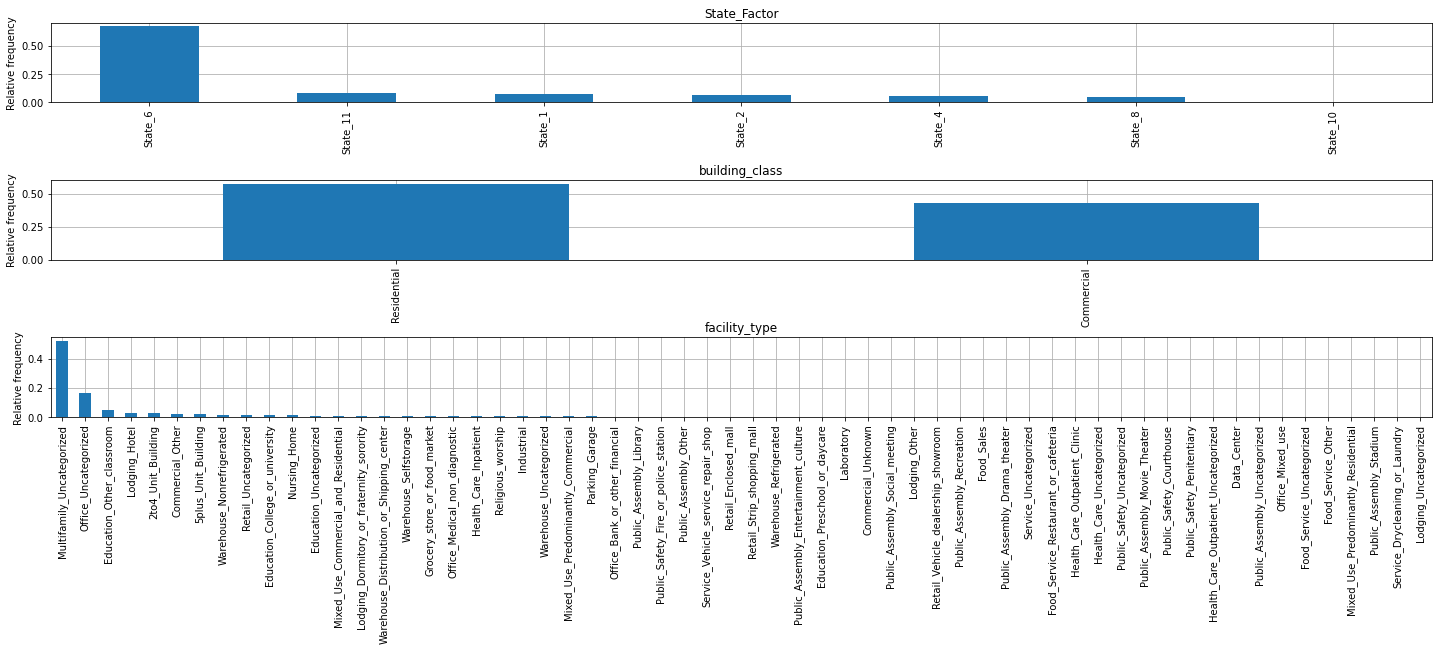

In [17]:
## Generating plots to study the relative frequency distribution of the categorical features

#' @param col: dataframe/Series
#' @param name: String
#' @param num: integer
#' @return a plot displaying the relative frequency distribution for the specified column

def plot_distbn(col, name, num):
    plt.subplot(num)
    col.value_counts(normalize=True).plot(kind='bar')
    plt.title(name)
    plt.ylabel('Relative frequency')
    plt.tight_layout()
    plt.grid(True)    
    return col.value_counts(normalize=True)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(20,6))
relative_frequency1 = plot_distbn(df['State_Factor'], 'State_Factor', 311)
relative_frequency2 = plot_distbn(df['building_class'], 'building_class', 312)
relative_frequency3 = plot_distbn(df['facility_type'], 'facility_type', 313)

In [18]:
## Dropping State_Factor due to huge imbalance in distribution
df = df.drop('State_Factor',1)

In [19]:
## Extracting the top 6 facility types from the distribution above
significant_categories = relative_frequency3.index[:6].tolist()
print(significant_categories)

['Multifamily_Uncategorized', 'Office_Uncategorized', 'Education_Other_classroom', 'Lodging_Hotel', '2to4_Unit_Building', 'Commercial_Other']


#### 1.4.1. Binning

In [20]:
## Binning insignificant facility types into 'Others' to deal with the imbalance in categorization (to reduce cardinality)
df['facility_type'].loc[~df['facility_type'].isin(significant_categories)] = 'Others'
df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,january_max_temp,february_min_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,Commercial,Others,61242.0,1942.0,11.0,2.4,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,Commercial,Others,274000.0,1955.0,45.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,Commercial,Others,280025.0,1951.0,97.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,Commercial,Others,66000.0,1985.0,100.0,2.4,50.5,68,35,...,56.972603,0,0,0,0,14,0,0,0,3.899395


### 1.5. Encoding Categorical Features

In [21]:
## Performing Ordinal Encoding on categorical features. 
## Each unique category value is assigned an integer value
## This results in a single column of integers (0 to n_categories - 1) per feature.
enc = OrdinalEncoder()

for col in df:
    if df[col].dtype =='object':
        df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

### 1.6. MinMax Scaling

In [22]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
scaled_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,january_max_temp,february_min_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,0.0,0.0,1.000000,0.009445,0.963772,0.11,0.004557,0.735725,0.530612,0.786885,...,0.380665,0.0,0.0,0.0,0.0,0.053846,0.0,0.0,0.0,0.248460
1,0.0,0.0,1.000000,0.042769,0.970223,0.45,0.004247,0.735725,0.530612,0.786885,...,0.380665,0.0,0.0,0.0,0.0,0.053846,0.0,0.0,0.0,0.025579
2,0.0,0.0,1.000000,0.043713,0.968238,0.97,0.004247,0.735725,0.530612,0.786885,...,0.380665,0.0,0.0,0.0,0.0,0.053846,0.0,0.0,0.0,0.023767
3,0.0,0.0,0.333333,0.008518,0.982630,0.46,0.004247,0.735725,0.530612,0.786885,...,0.380665,0.0,0.0,0.0,0.0,0.053846,0.0,0.0,0.0,0.047555
4,0.0,0.0,1.000000,0.010190,0.985112,1.00,0.004557,0.735725,0.530612,0.786885,...,0.380665,0.0,0.0,0.0,0.0,0.053846,0.0,0.0,0.0,0.002907


### 1.7. KNN Imputation

In [23]:
imputer = KNNImputer(n_neighbors=5)
scaled_df = pd.DataFrame(imputer.fit_transform(scaled_df),columns = scaled_df.columns)

In [24]:
scaled_df = scaler.inverse_transform(scaled_df)

In [25]:
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df.columns

In [26]:
scaled_df

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,january_max_temp,february_min_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1.0,0.0,6.0,61242.0,1942.0,11.0,2.4,50.500000,68.0,35.0,...,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,248.682615
1,1.0,0.0,6.0,274000.0,1955.0,45.0,1.8,50.500000,68.0,35.0,...,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,26.500150
2,1.0,0.0,6.0,280025.0,1951.0,97.0,1.8,50.500000,68.0,35.0,...,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,24.693619
3,1.0,0.0,2.0,55325.0,1980.0,46.0,1.8,50.500000,68.0,35.0,...,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,48.406926
4,1.0,0.0,6.0,66000.0,1985.0,100.0,2.4,50.500000,68.0,35.0,...,56.972603,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75713,6.0,0.0,5.0,20410.0,1995.0,8.0,36.6,43.451613,56.0,34.0,...,55.147541,6.0,0.0,0.0,0.0,25.0,3.0,0.0,0.0,132.918411
75714,6.0,1.0,6.0,40489.0,1910.0,98.0,36.6,43.451613,56.0,34.0,...,55.147541,6.0,0.0,0.0,0.0,25.0,3.0,0.0,0.0,39.483672
75715,6.0,0.0,1.0,28072.0,1917.0,69.4,36.6,36.612903,48.0,30.0,...,47.911202,26.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,48.404398
75716,6.0,0.0,1.0,53575.0,2012.0,72.4,36.6,36.612903,48.0,30.0,...,47.911202,26.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,592.022750


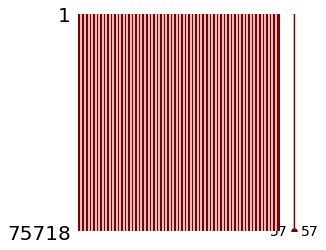

In [27]:
msno.matrix(scaled_df, figsize=(4,4), color=(0.5,0,0))

### 1.8. Dealing with Extreme Values

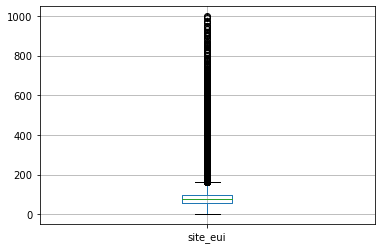

In [28]:
pd.DataFrame(scaled_df['site_eui']).boxplot()

In [29]:
## Using IQR (Interquartile Range) method to remove outlier from the dataset
for x in ['site_eui']:
    q75, q25 = np.percentile(scaled_df.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    ul = q75+(1.5*intr_qr)
    ll = q25-(1.5*intr_qr)
    
    scaled_df.loc[scaled_df[x]<ll,x] = np.nan
    scaled_df.loc[scaled_df[x]>ul,x] = np.nan

## Number of outliers    
scaled_df['site_eui'].isnull().sum()

3845

In [30]:
df = scaled_df.dropna(axis = 0)

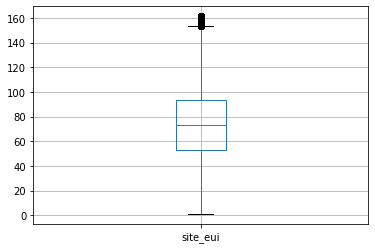

In [31]:
pd.DataFrame(df['site_eui']).boxplot()

In [32]:
## numeric features
numeric = []
for col in df.columns:
    if df[col].dtype != 'object':
        numeric.append(col)

In [33]:
df.to_csv('data/1_eda.csv',index = False)